# 6614450115 นางสาวพัชรภรณ์ โสภณพงษ์

## Using Keras to Build and Train Neural Networks

In this exercise we will use a neural network to predict diabetes using the Pima Diabetes Dataset.  We will start by training a Random Forest to get a performance baseline.  Then we will use the Keras package to quickly build and train a neural network and compare the performance.  We will see how different network structures affect the performance, training time, and level of overfitting (or underfitting).

## Pima Diabetes Dataset

* Kaggle Dataset (https://www.kaggle.com/datasets/kumargh/pimaindiansdiabetescsv)


### Attributes: (all numeric-valued)
   1. Number of times pregnant
   2. Plasma glucose concentration a 2 hours in an oral glucose tolerance test
   3. Diastolic blood pressure (mm Hg)
   4. Triceps skin fold thickness (mm)
   5. 2-Hour serum insulin (mu U/ml)
   6. Body mass index (weight in kg/(height in m)^2)
   7. Diabetes pedigree function
   8. Age (years)
   9. Class variable (0 or 1)

The UCI Pima Diabetes Dataset which has 8 numerical predictors and a binary outcome.

In [1]:
#Preliminaries

from __future__ import absolute_import, division, print_function  # Python 2/3 compatibility

import warnings
warnings.filterwarnings("ignore")


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_auc_score, roc_curve, accuracy_score
from sklearn.ensemble import RandomForestClassifier

import seaborn as sns

%matplotlib inline

In [2]:
## Import Keras objects for Deep Learning

from keras.models  import Sequential
from keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization
from keras.optimizers import Adam, SGD, RMSprop

2023-08-02 19:49:06.058776: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
## Load in the data set (Internet Access needed)
# Download pima-indians-diabetes.csv from https://www.kaggle.com/datasets/kumargh/pimaindiansdiabetescsv

url = "pima-indians-diabetes.csv"
names = ["times_pregnant", "glucose_tolerance_test", "blood_pressure", "skin_thickness", "insulin",
         "bmi", "pedigree_function", "age", "has_diabetes"]
diabetes_df = pd.read_csv(url, names=names)

In [4]:
# Take a peek at the data -- if there are lots of "NaN" you may have internet connectivity issues
print(diabetes_df.shape)
diabetes_df.sample(5)

(768, 9)


,times_pregnant,glucose_tolerance_test,blood_pressure,skin_thickness,insulin,bmi,pedigree_function,age,has_diabetes
472,0,119,66,27,0,38.8,0.259,22,0
170,6,102,82,0,0,30.8,0.180,36,1
301,2,144,58,33,135,31.6,0.422,25,1
358,12,88,74,40,54,35.3,0.378,48,0
158,2,88,74,19,53,29.0,0.229,22,0


In [5]:
X = diabetes_df.iloc[:, :-1].values
y = diabetes_df["has_diabetes"].values

In [6]:
# Split the data to Train, and Test (75%, 25%)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=11111)

In [7]:
np.mean(y), np.mean(1-y)

(0.3489583333333333, 0.6510416666666666)

Above, we see that about 35% of the patients in this dataset have diabetes, while 65% do not.  This means we can get an accuracy of 65% without any model - just declare that no one has diabetes. We will calculate the ROC-AUC score to evaluate performance of our model, and also look at the accuracy as well to see if we improved upon the 65% accuracy.
## Exercise: Get a baseline performance using Random Forest
To begin, and get a baseline for classifier performance:
1. Train a Random Forest model with 200 trees on the training data.
2. Calculate the accuracy and roc_auc_score of the predictions.

In [8]:
## Train the RF Model
rf_model = RandomForestClassifier(n_estimators=200)
rf_model.fit(X_train, y_train)

RandomForestClassifier(n_estimators=200)

In [9]:
# Make predictions on the test set - both "hard" predictions, and the scores (percent of trees voting yes)
y_pred_class_rf = rf_model.predict(X_test)
y_pred_prob_rf = rf_model.predict_proba(X_test)

print('accuracy is {:.3f}'.format(accuracy_score(y_test, y_pred_class_rf)))
print('roc-auc is {:.3f}'.format(roc_auc_score(y_test, y_pred_prob_rf[:,1])))

accuracy is 0.766
roc-auc is 0.830


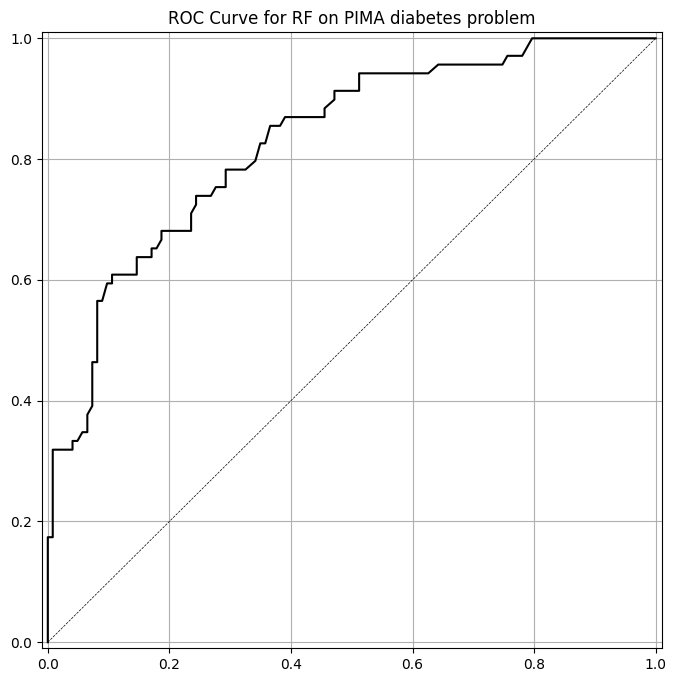

In [10]:
def plot_roc(y_test, y_pred, model_name):
    fpr, tpr, thr = roc_curve(y_test, y_pred)
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.plot(fpr, tpr, 'k-')
    ax.plot([0, 1], [0, 1], 'k--', linewidth=.5)  # roc curve for random model
    ax.grid(True)
    ax.set(title='ROC Curve for {} on PIMA diabetes problem'.format(model_name),
           xlim=[-0.01, 1.01], ylim=[-0.01, 1.01])

plot_roc(y_test, y_pred_prob_rf[:, 1], 'RF')

## Build a Single Hidden Layer Neural Network

We will use the Sequential model to quickly build a neural network.  Our first network will be a single layer network.  We have 8 variables, so we set the input shape to 8.  Let's start by having a single hidden layer with 12 nodes.

In [11]:
## First let's normalize the data
## This aids the training of neural nets by providing numerical stability
## Random Forest does not need this as it finds a split only, as opposed to performing matrix multiplications

normalizer = StandardScaler()
X_train_norm = normalizer.fit_transform(X_train)
X_test_norm = normalizer.transform(X_test)


In [12]:
# Define the Model
# Input size is 8-dimensional
# 1 hidden layer, 12 hidden nodes, sigmoid activation
# Final layer has just one node with a sigmoid activation (standard for binary classification)
#HW ปรับจูน model ให้มีค่ามากกว่า accuracy is 0.766 ,roc-auc is 0.820 ที่เป็น model random forest
model_1 = Sequential([
    Dense(12, input_shape=(8,), activation="relu"),
    Dense(1, activation="sigmoid")
])

2023-08-02 19:49:17.809571: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [13]:
#  This is a nice tool to view the model you have created and count the parameters

model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 12)                108       
                                                                 
 dense_1 (Dense)             (None, 1)                 13        
                                                                 
Total params: 121
Trainable params: 121
Non-trainable params: 0
_________________________________________________________________


### Comprehension question:
Why do we have 121 parameters?  Does that make sense?


Let's fit our model for 200 epochs.

In [14]:
# Fit(Train) the Model
# Compile the model with Optimizer, Loss Function and Metrics
# Roc-Auc is not available in Keras as an off the shelf metric yet, so we will skip it here.

model_1.compile(optimizer=SGD(learning_rate=0.005), loss="binary_crossentropy", metrics=["accuracy"])

run_hist_1 = model_1.fit(X_train_norm, y_train, validation_data=(X_test_norm, y_test), epochs=200, batch_size=32)
# the fit function returns the run history.
# It is very convenient, as it contains information about the model fit, iterations etc.

Epoch 1/200
18/18 [==============================] - 1s 12ms/step - loss: 0.7240 - accuracy: 0.5677 - val_loss: 0.6870 - val_accuracy: 0.6354
Epoch 2/200
18/18 [==============================] - 0s 3ms/step - loss: 0.7148 - accuracy: 0.5799 - val_loss: 0.6790 - val_accuracy: 0.6406
Epoch 3/200
18/18 [==============================] - 0s 3ms/step - loss: 0.7063 - accuracy: 0.5851 - val_loss: 0.6715 - val_accuracy: 0.6458
Epoch 4/200
18/18 [==============================] - 0s 2ms/step - loss: 0.6983 - accuracy: 0.5972 - val_loss: 0.6645 - val_accuracy: 0.6615
Epoch 5/200
18/18 [==============================] - 0s 2ms/step - loss: 0.6909 - accuracy: 0.6042 - val_loss: 0.6580 - val_accuracy: 0.6771
Epoch 6/200
18/18 [==============================] - 0s 2ms/step - loss: 0.6841 - accuracy: 0.6111 - val_loss: 0.6518 - val_accuracy: 0.6927
Epoch 7/200
18/18 [==============================] - 0s 3ms/step - loss: 0.6776 - accuracy: 0.6215 - val_loss: 0.6459 - val_accuracy: 0.6979
Epoch 8/200


Epoch 59/200
18/18 [==============================] - 0s 3ms/step - loss: 0.5376 - accuracy: 0.7257 - val_loss: 0.5260 - val_accuracy: 0.7604
Epoch 60/200
18/18 [==============================] - 0s 2ms/step - loss: 0.5362 - accuracy: 0.7240 - val_loss: 0.5251 - val_accuracy: 0.7604
Epoch 61/200
18/18 [==============================] - 0s 2ms/step - loss: 0.5350 - accuracy: 0.7222 - val_loss: 0.5241 - val_accuracy: 0.7604
Epoch 62/200
18/18 [==============================] - 0s 2ms/step - loss: 0.5337 - accuracy: 0.7240 - val_loss: 0.5232 - val_accuracy: 0.7604
Epoch 63/200
18/18 [==============================] - 0s 2ms/step - loss: 0.5324 - accuracy: 0.7240 - val_loss: 0.5223 - val_accuracy: 0.7604
Epoch 64/200
18/18 [==============================] - 0s 2ms/step - loss: 0.5312 - accuracy: 0.7257 - val_loss: 0.5214 - val_accuracy: 0.7604
Epoch 65/200
18/18 [==============================] - 0s 2ms/step - loss: 0.5299 - accuracy: 0.7257 - val_loss: 0.5205 - val_accuracy: 0.7552
Epoch 

18/18 [==============================] - 0s 2ms/step - loss: 0.4611 - accuracy: 0.7778 - val_loss: 0.4864 - val_accuracy: 0.7760
Epoch 174/200
18/18 [==============================] - 0s 2ms/step - loss: 0.4610 - accuracy: 0.7778 - val_loss: 0.4864 - val_accuracy: 0.7760
Epoch 175/200
18/18 [==============================] - 0s 2ms/step - loss: 0.4607 - accuracy: 0.7760 - val_loss: 0.4864 - val_accuracy: 0.7760
Epoch 176/200
18/18 [==============================] - 0s 2ms/step - loss: 0.4605 - accuracy: 0.7795 - val_loss: 0.4864 - val_accuracy: 0.7760
Epoch 177/200
18/18 [==============================] - 0s 2ms/step - loss: 0.4602 - accuracy: 0.7778 - val_loss: 0.4864 - val_accuracy: 0.7760
Epoch 178/200
18/18 [==============================] - 0s 2ms/step - loss: 0.4601 - accuracy: 0.7778 - val_loss: 0.4864 - val_accuracy: 0.7760
Epoch 179/200
18/18 [==============================] - 0s 2ms/step - loss: 0.4598 - accuracy: 0.7778 - val_loss: 0.4864 - val_accuracy: 0.7760
Epoch 180/200

In [15]:
## Like we did for the Random Forest, we generate two kinds of predictions
#  One is a hard decision, the other is a probabilitistic score.

y_pred_prob_nn_1 = model_1.predict(X_test_norm)
y_pred_class_nn_1 = (y_pred_prob_nn_1 >= 0.5).astype('int32')

6/6 [==============================] - 0s 1ms/step


In [16]:
# Let's check out the outputs to get a feel for how keras apis work.
y_pred_class_nn_1[:10]

array([[0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0]], dtype=int32)

In [17]:
y_pred_prob_nn_1[:10]

array([[0.46633855],
       [0.79869395],
       [0.260224  ],
       [0.19876017],
       [0.23147713],
       [0.48477837],
       [0.04759319],
       [0.37602586],
       [0.8762017 ],
       [0.23022832]], dtype=float32)

accuracy is 0.760
roc-auc is 0.827


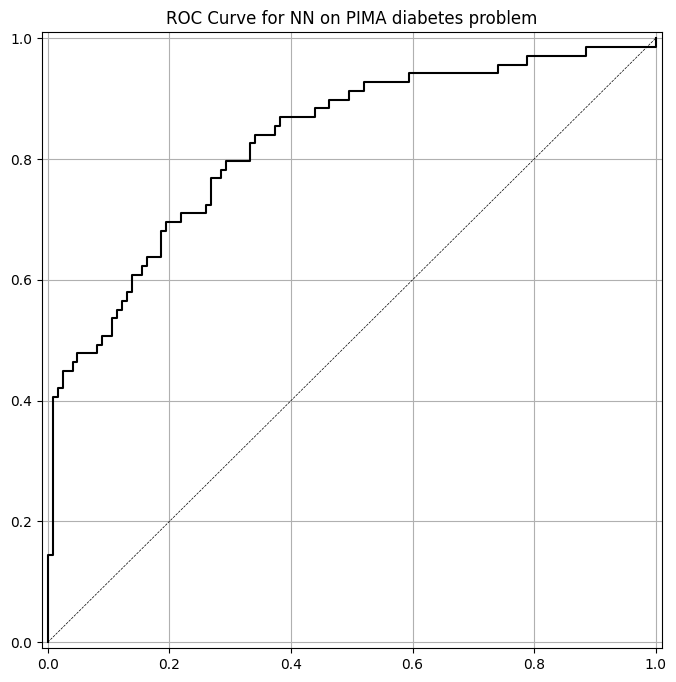

In [18]:
# Print model performance and plot the roc curve
print('accuracy is {:.3f}'.format(accuracy_score(y_test, y_pred_class_nn_1)))
print('roc-auc is {:.3f}'.format(roc_auc_score(y_test, y_pred_prob_nn_1)))

plot_roc(y_test, y_pred_prob_nn_1, 'NN')

There may be some variation in exact numbers due to randomness, but you should get results in the same ballpark as the Random Forest - between 75% and 85% accuracy, between .8 and .9 for AUC.

Let's look at the `run_hist_1` object that was created, specifically its `history` attribute.

In [19]:
run_hist_1.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

Let's plot the training loss and the validation loss over the different epochs and see how it looks.

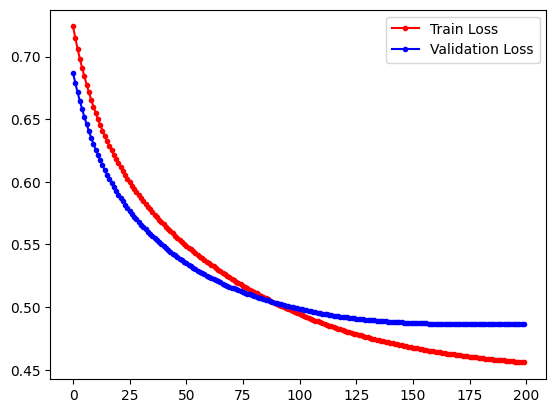

In [20]:
fig, ax = plt.subplots()
ax.plot(run_hist_1.history["loss"],'r', marker='.', label="Train Loss")
ax.plot(run_hist_1.history["val_loss"],'b', marker='.', label="Validation Loss")
ax.legend()

Looks like the losses are still going down on both the training set and the validation set.  This suggests that the model might benefit from further training.  Let's train the model a little more and see what happens. Note that it will pick up from where it left off. Train for 1000 more epochs.

In [21]:
## Note that when we call "fit" again, it picks up where it left off
run_hist_1b = model_1.fit(X_train_norm, y_train, validation_data=(X_test_norm, y_test), epochs=1000, batch_size=32)

Epoch 1/1000
18/18 [==============================] - 0s 4ms/step - loss: 0.4557 - accuracy: 0.7830 - val_loss: 0.4867 - val_accuracy: 0.7604
Epoch 2/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.4555 - accuracy: 0.7830 - val_loss: 0.4867 - val_accuracy: 0.7604
Epoch 3/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.4554 - accuracy: 0.7830 - val_loss: 0.4867 - val_accuracy: 0.7604
Epoch 4/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.4552 - accuracy: 0.7830 - val_loss: 0.4867 - val_accuracy: 0.7604
Epoch 5/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.4550 - accuracy: 0.7830 - val_loss: 0.4868 - val_accuracy: 0.7604
Epoch 6/1000
18/18 [==============================] - 0s 3ms/step - loss: 0.4549 - accuracy: 0.7830 - val_loss: 0.4868 - val_accuracy: 0.7604
Epoch 7/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.4547 - accuracy: 0.7830 - val_loss: 0.4868 - val_accuracy: 0.7604
Epoch 

18/18 [==============================] - 0s 2ms/step - loss: 0.4439 - accuracy: 0.7969 - val_loss: 0.4905 - val_accuracy: 0.7552
Epoch 116/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.4438 - accuracy: 0.7986 - val_loss: 0.4905 - val_accuracy: 0.7552
Epoch 117/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.4438 - accuracy: 0.7986 - val_loss: 0.4906 - val_accuracy: 0.7552
Epoch 118/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.4437 - accuracy: 0.7986 - val_loss: 0.4906 - val_accuracy: 0.7552
Epoch 119/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.4437 - accuracy: 0.7986 - val_loss: 0.4906 - val_accuracy: 0.7552
Epoch 120/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.4436 - accuracy: 0.7986 - val_loss: 0.4906 - val_accuracy: 0.7552
Epoch 121/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.4435 - accuracy: 0.7986 - val_loss: 0.4907 - val_accuracy: 0.7552
Epoch 1

Epoch 172/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.4407 - accuracy: 0.7986 - val_loss: 0.4916 - val_accuracy: 0.7500
Epoch 173/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.4406 - accuracy: 0.7986 - val_loss: 0.4916 - val_accuracy: 0.7500
Epoch 174/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.4405 - accuracy: 0.8003 - val_loss: 0.4917 - val_accuracy: 0.7500
Epoch 175/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.4405 - accuracy: 0.7986 - val_loss: 0.4917 - val_accuracy: 0.7500
Epoch 176/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.4405 - accuracy: 0.8003 - val_loss: 0.4917 - val_accuracy: 0.7500
Epoch 177/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.4404 - accuracy: 0.7986 - val_loss: 0.4917 - val_accuracy: 0.7500
Epoch 178/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.4404 - accuracy: 0.7986 - val_loss: 0.4917 - val_accuracy:

Epoch 229/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.4375 - accuracy: 0.7986 - val_loss: 0.4924 - val_accuracy: 0.7500
Epoch 230/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.4375 - accuracy: 0.7986 - val_loss: 0.4925 - val_accuracy: 0.7500
Epoch 231/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.4374 - accuracy: 0.7986 - val_loss: 0.4925 - val_accuracy: 0.7500
Epoch 232/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.4374 - accuracy: 0.7969 - val_loss: 0.4925 - val_accuracy: 0.7500
Epoch 233/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.4373 - accuracy: 0.7986 - val_loss: 0.4925 - val_accuracy: 0.7500
Epoch 234/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.4373 - accuracy: 0.7986 - val_loss: 0.4925 - val_accuracy: 0.7500
Epoch 235/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.4372 - accuracy: 0.7986 - val_loss: 0.4925 - val_accuracy:

Epoch 286/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.4346 - accuracy: 0.7986 - val_loss: 0.4934 - val_accuracy: 0.7500
Epoch 287/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.4345 - accuracy: 0.7969 - val_loss: 0.4934 - val_accuracy: 0.7500
Epoch 288/1000
18/18 [==============================] - 0s 3ms/step - loss: 0.4345 - accuracy: 0.7969 - val_loss: 0.4934 - val_accuracy: 0.7500
Epoch 289/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.4344 - accuracy: 0.7986 - val_loss: 0.4934 - val_accuracy: 0.7500
Epoch 290/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.4344 - accuracy: 0.7969 - val_loss: 0.4934 - val_accuracy: 0.7500
Epoch 291/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.4343 - accuracy: 0.7969 - val_loss: 0.4935 - val_accuracy: 0.7500
Epoch 292/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.4342 - accuracy: 0.7986 - val_loss: 0.4935 - val_accuracy:

Epoch 343/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.4318 - accuracy: 0.7969 - val_loss: 0.4939 - val_accuracy: 0.7604
Epoch 344/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.4318 - accuracy: 0.7969 - val_loss: 0.4939 - val_accuracy: 0.7604
Epoch 345/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.4317 - accuracy: 0.7969 - val_loss: 0.4939 - val_accuracy: 0.7604
Epoch 346/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.4317 - accuracy: 0.7969 - val_loss: 0.4939 - val_accuracy: 0.7604
Epoch 347/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.4316 - accuracy: 0.7969 - val_loss: 0.4939 - val_accuracy: 0.7604
Epoch 348/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.4316 - accuracy: 0.7969 - val_loss: 0.4939 - val_accuracy: 0.7604
Epoch 349/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.4316 - accuracy: 0.7969 - val_loss: 0.4938 - val_accuracy:

Epoch 400/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.4291 - accuracy: 0.7951 - val_loss: 0.4941 - val_accuracy: 0.7604
Epoch 401/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.4290 - accuracy: 0.7951 - val_loss: 0.4941 - val_accuracy: 0.7604
Epoch 402/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.4290 - accuracy: 0.7917 - val_loss: 0.4941 - val_accuracy: 0.7604
Epoch 403/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.4290 - accuracy: 0.7934 - val_loss: 0.4941 - val_accuracy: 0.7604
Epoch 404/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.4289 - accuracy: 0.7934 - val_loss: 0.4941 - val_accuracy: 0.7604
Epoch 405/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.4289 - accuracy: 0.7934 - val_loss: 0.4941 - val_accuracy: 0.7604
Epoch 406/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.4288 - accuracy: 0.7951 - val_loss: 0.4941 - val_accuracy:

Epoch 457/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.4264 - accuracy: 0.7934 - val_loss: 0.4947 - val_accuracy: 0.7604
Epoch 458/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.4264 - accuracy: 0.7934 - val_loss: 0.4947 - val_accuracy: 0.7604
Epoch 459/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.4264 - accuracy: 0.7934 - val_loss: 0.4947 - val_accuracy: 0.7604
Epoch 460/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.4263 - accuracy: 0.7934 - val_loss: 0.4947 - val_accuracy: 0.7604
Epoch 461/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.4263 - accuracy: 0.7934 - val_loss: 0.4947 - val_accuracy: 0.7552
Epoch 462/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.4263 - accuracy: 0.7934 - val_loss: 0.4947 - val_accuracy: 0.7552
Epoch 463/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.4263 - accuracy: 0.7934 - val_loss: 0.4947 - val_accuracy:

Epoch 514/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.4241 - accuracy: 0.7951 - val_loss: 0.4949 - val_accuracy: 0.7604
Epoch 515/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.4240 - accuracy: 0.7951 - val_loss: 0.4949 - val_accuracy: 0.7604
Epoch 516/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.4240 - accuracy: 0.7951 - val_loss: 0.4949 - val_accuracy: 0.7604
Epoch 517/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.4240 - accuracy: 0.7951 - val_loss: 0.4949 - val_accuracy: 0.7604
Epoch 518/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.4239 - accuracy: 0.7951 - val_loss: 0.4950 - val_accuracy: 0.7604
Epoch 519/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.4239 - accuracy: 0.7951 - val_loss: 0.4950 - val_accuracy: 0.7604
Epoch 520/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.4238 - accuracy: 0.7951 - val_loss: 0.4950 - val_accuracy:

Epoch 571/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.4218 - accuracy: 0.7969 - val_loss: 0.4954 - val_accuracy: 0.7604
Epoch 572/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.4218 - accuracy: 0.7951 - val_loss: 0.4954 - val_accuracy: 0.7604
Epoch 573/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.4218 - accuracy: 0.7969 - val_loss: 0.4954 - val_accuracy: 0.7552
Epoch 574/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.4218 - accuracy: 0.7969 - val_loss: 0.4954 - val_accuracy: 0.7552
Epoch 575/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.4217 - accuracy: 0.7986 - val_loss: 0.4954 - val_accuracy: 0.7552
Epoch 576/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.4217 - accuracy: 0.7969 - val_loss: 0.4954 - val_accuracy: 0.7552
Epoch 577/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.4217 - accuracy: 0.7986 - val_loss: 0.4954 - val_accuracy:

Epoch 628/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.4200 - accuracy: 0.7969 - val_loss: 0.4962 - val_accuracy: 0.7552
Epoch 629/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.4199 - accuracy: 0.7969 - val_loss: 0.4963 - val_accuracy: 0.7552
Epoch 630/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.4199 - accuracy: 0.7969 - val_loss: 0.4963 - val_accuracy: 0.7552
Epoch 631/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.4198 - accuracy: 0.7969 - val_loss: 0.4963 - val_accuracy: 0.7552
Epoch 632/1000
18/18 [==============================] - 0s 3ms/step - loss: 0.4198 - accuracy: 0.7969 - val_loss: 0.4963 - val_accuracy: 0.7552
Epoch 633/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.4198 - accuracy: 0.7969 - val_loss: 0.4963 - val_accuracy: 0.7552
Epoch 634/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.4197 - accuracy: 0.7969 - val_loss: 0.4963 - val_accuracy:

Epoch 685/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.4181 - accuracy: 0.8003 - val_loss: 0.4972 - val_accuracy: 0.7552
Epoch 686/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.4181 - accuracy: 0.8003 - val_loss: 0.4972 - val_accuracy: 0.7552
Epoch 687/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.4181 - accuracy: 0.8021 - val_loss: 0.4972 - val_accuracy: 0.7552
Epoch 688/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.4180 - accuracy: 0.8003 - val_loss: 0.4972 - val_accuracy: 0.7552
Epoch 689/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.4180 - accuracy: 0.8003 - val_loss: 0.4972 - val_accuracy: 0.7552
Epoch 690/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.4180 - accuracy: 0.8003 - val_loss: 0.4973 - val_accuracy: 0.7552
Epoch 691/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.4180 - accuracy: 0.8003 - val_loss: 0.4973 - val_accuracy:

Epoch 742/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.4164 - accuracy: 0.8003 - val_loss: 0.4980 - val_accuracy: 0.7552
Epoch 743/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.4164 - accuracy: 0.8021 - val_loss: 0.4980 - val_accuracy: 0.7552
Epoch 744/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.4164 - accuracy: 0.8003 - val_loss: 0.4980 - val_accuracy: 0.7552
Epoch 745/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.4163 - accuracy: 0.8021 - val_loss: 0.4980 - val_accuracy: 0.7552
Epoch 746/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.4164 - accuracy: 0.8021 - val_loss: 0.4980 - val_accuracy: 0.7552
Epoch 747/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.4163 - accuracy: 0.8021 - val_loss: 0.4980 - val_accuracy: 0.7552
Epoch 748/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.4163 - accuracy: 0.8021 - val_loss: 0.4980 - val_accuracy:

Epoch 799/1000
18/18 [==============================] - 0s 3ms/step - loss: 0.4143 - accuracy: 0.8003 - val_loss: 0.4986 - val_accuracy: 0.7656
Epoch 800/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.4143 - accuracy: 0.8003 - val_loss: 0.4987 - val_accuracy: 0.7656
Epoch 801/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.4143 - accuracy: 0.8003 - val_loss: 0.4987 - val_accuracy: 0.7656
Epoch 802/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.4142 - accuracy: 0.8003 - val_loss: 0.4987 - val_accuracy: 0.7656
Epoch 803/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.4142 - accuracy: 0.8021 - val_loss: 0.4987 - val_accuracy: 0.7656
Epoch 804/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.4142 - accuracy: 0.8021 - val_loss: 0.4987 - val_accuracy: 0.7656
Epoch 805/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.4142 - accuracy: 0.8003 - val_loss: 0.4987 - val_accuracy:

Epoch 856/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.4123 - accuracy: 0.8003 - val_loss: 0.4993 - val_accuracy: 0.7656
Epoch 857/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.4123 - accuracy: 0.8003 - val_loss: 0.4993 - val_accuracy: 0.7656
Epoch 858/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.4123 - accuracy: 0.8021 - val_loss: 0.4993 - val_accuracy: 0.7656
Epoch 859/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.4122 - accuracy: 0.8003 - val_loss: 0.4993 - val_accuracy: 0.7656
Epoch 860/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.4122 - accuracy: 0.8003 - val_loss: 0.4994 - val_accuracy: 0.7656
Epoch 861/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.4121 - accuracy: 0.8003 - val_loss: 0.4994 - val_accuracy: 0.7656
Epoch 862/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.4121 - accuracy: 0.8003 - val_loss: 0.4994 - val_accuracy:

Epoch 913/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.4104 - accuracy: 0.8021 - val_loss: 0.4999 - val_accuracy: 0.7760
Epoch 914/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.4103 - accuracy: 0.8021 - val_loss: 0.4999 - val_accuracy: 0.7760
Epoch 915/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.4102 - accuracy: 0.8021 - val_loss: 0.5000 - val_accuracy: 0.7760
Epoch 916/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.4103 - accuracy: 0.8021 - val_loss: 0.5000 - val_accuracy: 0.7760
Epoch 917/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.4102 - accuracy: 0.8021 - val_loss: 0.5000 - val_accuracy: 0.7760
Epoch 918/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.4102 - accuracy: 0.8021 - val_loss: 0.5000 - val_accuracy: 0.7760
Epoch 919/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.4101 - accuracy: 0.8021 - val_loss: 0.5000 - val_accuracy:

Epoch 970/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.4086 - accuracy: 0.8038 - val_loss: 0.5008 - val_accuracy: 0.7760
Epoch 971/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.4086 - accuracy: 0.8038 - val_loss: 0.5008 - val_accuracy: 0.7760
Epoch 972/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.4085 - accuracy: 0.8038 - val_loss: 0.5008 - val_accuracy: 0.7760
Epoch 973/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.4085 - accuracy: 0.8038 - val_loss: 0.5008 - val_accuracy: 0.7708
Epoch 974/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.4084 - accuracy: 0.8056 - val_loss: 0.5008 - val_accuracy: 0.7708
Epoch 975/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.4085 - accuracy: 0.8038 - val_loss: 0.5009 - val_accuracy: 0.7708
Epoch 976/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.4085 - accuracy: 0.8038 - val_loss: 0.5009 - val_accuracy:

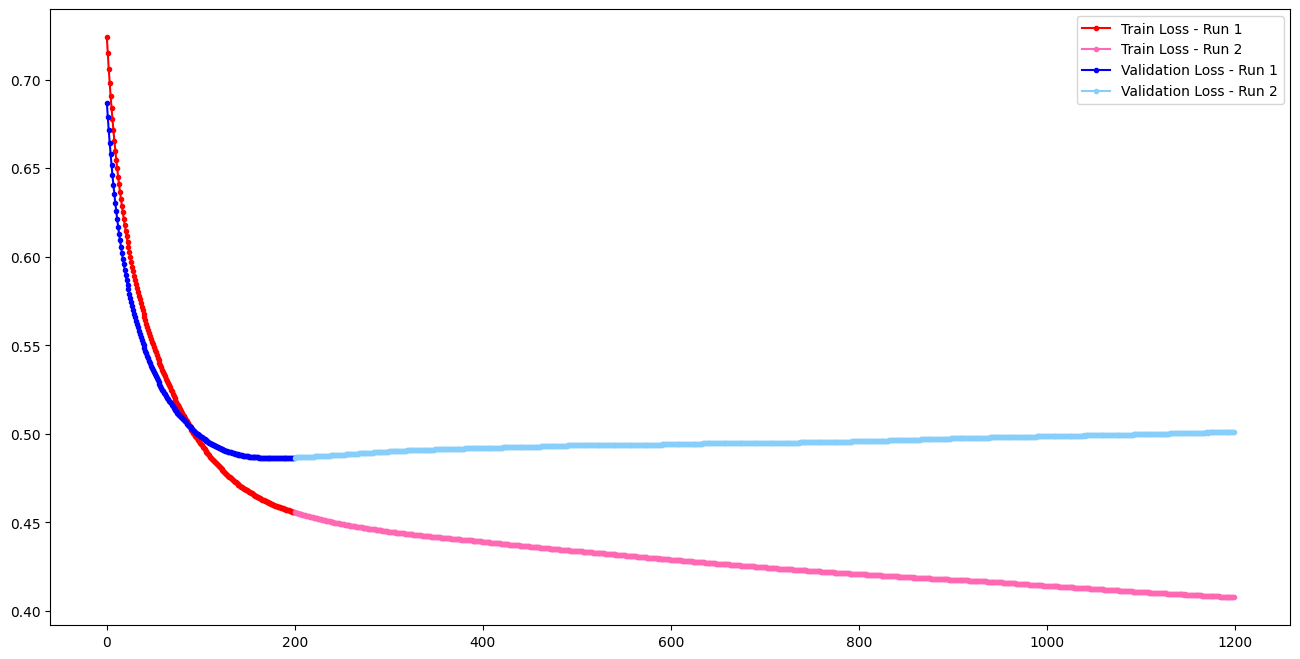

In [22]:
n = len(run_hist_1.history["loss"])
m = len(run_hist_1b.history['loss'])
fig, ax = plt.subplots(figsize=(16, 8))

ax.plot(range(n), run_hist_1.history["loss"],'r', marker='.', label="Train Loss - Run 1")
ax.plot(range(n, n+m), run_hist_1b.history["loss"], 'hotpink', marker='.', label="Train Loss - Run 2")

ax.plot(range(n), run_hist_1.history["val_loss"],'b', marker='.', label="Validation Loss - Run 1")
ax.plot(range(n, n+m), run_hist_1b.history["val_loss"], 'LightSkyBlue', marker='.',  label="Validation Loss - Run 2")

ax.legend()

Note that this graph begins where the other left off.  While the training loss is still going down, it looks like the validation loss has stabilized (or even gotten worse!).  This suggests that our network will not benefit from further training.  What is the appropriate number of epochs?

## Exercise
Now it's your turn.  Train your new model, here is a suggestion:
- Build a model with two hidden layers, each with 6 nodes
- Use the "relu" activation function for the hidden layers, and "sigmoid" for the final layer
- Use a learning rate of 0.003 and train for 1500 epochs
- Graph the trajectory of the values of loss and accuracy on both train and test set
- Plot the roc curve for the predictions

You probably need to experiment with different learning rates, numbers of epochs, and network structures.

In [23]:
model_new = Sequential([
    Dense(6, input_shape=(8,), activation="relu"),
    dropout()
    Dense(6, input_shape= (6,), activation="relu"),
    Dense(1, activation="sigmoid")    #output layer
])
model_new.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 6)                 54        
                                                                 
 dense_3 (Dense)             (None, 6)                 42        
                                                                 
 dense_4 (Dense)             (None, 1)                 7         
                                                                 
Total params: 103
Trainable params: 103
Non-trainable params: 0
_________________________________________________________________


In [24]:
model_new.compile(SGD(lr = 0.005), "binary_crossentropy", metrics=["accuracy"])
model_new.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 6)                 54        
                                                                 
 dense_3 (Dense)             (None, 6)                 42        
                                                                 
 dense_4 (Dense)             (None, 1)                 7         
                                                                 
Total params: 103
Trainable params: 103
Non-trainable params: 0
_________________________________________________________________


In [25]:
run_hist_new = model_new.fit(X_train_norm, y_train, validation_data=(X_test_norm, y_test), epochs=1500)

Epoch 1/1500
18/18 [==============================] - 0s 10ms/step - loss: 0.6917 - accuracy: 0.6632 - val_loss: 0.7101 - val_accuracy: 0.6302
Epoch 2/1500
18/18 [==============================] - 0s 3ms/step - loss: 0.6881 - accuracy: 0.6736 - val_loss: 0.7062 - val_accuracy: 0.6406
Epoch 3/1500
18/18 [==============================] - 0s 4ms/step - loss: 0.6846 - accuracy: 0.6719 - val_loss: 0.7025 - val_accuracy: 0.6406
Epoch 4/1500
18/18 [==============================] - 0s 13ms/step - loss: 0.6813 - accuracy: 0.6719 - val_loss: 0.6988 - val_accuracy: 0.6458
Epoch 5/1500
18/18 [==============================] - 0s 3ms/step - loss: 0.6780 - accuracy: 0.6736 - val_loss: 0.6953 - val_accuracy: 0.6510
Epoch 6/1500
18/18 [==============================] - 0s 3ms/step - loss: 0.6748 - accuracy: 0.6701 - val_loss: 0.6919 - val_accuracy: 0.6458
Epoch 7/1500
18/18 [==============================] - 0s 3ms/step - loss: 0.6717 - accuracy: 0.6736 - val_loss: 0.6885 - val_accuracy: 0.6562
Epoc

18/18 [==============================] - 0s 3ms/step - loss: 0.4974 - accuracy: 0.7465 - val_loss: 0.5279 - val_accuracy: 0.7396
Epoch 116/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4967 - accuracy: 0.7448 - val_loss: 0.5274 - val_accuracy: 0.7396
Epoch 117/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4960 - accuracy: 0.7465 - val_loss: 0.5270 - val_accuracy: 0.7396
Epoch 118/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4954 - accuracy: 0.7465 - val_loss: 0.5266 - val_accuracy: 0.7396
Epoch 119/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4946 - accuracy: 0.7465 - val_loss: 0.5262 - val_accuracy: 0.7396
Epoch 120/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4940 - accuracy: 0.7465 - val_loss: 0.5258 - val_accuracy: 0.7396
Epoch 121/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4933 - accuracy: 0.7483 - val_loss: 0.5254 - val_accuracy: 0.7396
Epoch 1

Epoch 172/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4692 - accuracy: 0.7639 - val_loss: 0.5159 - val_accuracy: 0.7240
Epoch 173/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4689 - accuracy: 0.7622 - val_loss: 0.5158 - val_accuracy: 0.7240
Epoch 174/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4686 - accuracy: 0.7622 - val_loss: 0.5158 - val_accuracy: 0.7292
Epoch 175/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4682 - accuracy: 0.7622 - val_loss: 0.5157 - val_accuracy: 0.7292
Epoch 176/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4679 - accuracy: 0.7622 - val_loss: 0.5156 - val_accuracy: 0.7292
Epoch 177/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4676 - accuracy: 0.7622 - val_loss: 0.5155 - val_accuracy: 0.7292
Epoch 178/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4673 - accuracy: 0.7622 - val_loss: 0.5155 - val_accuracy:

Epoch 229/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4542 - accuracy: 0.7656 - val_loss: 0.5170 - val_accuracy: 0.7448
Epoch 230/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4540 - accuracy: 0.7674 - val_loss: 0.5171 - val_accuracy: 0.7448
Epoch 231/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4539 - accuracy: 0.7674 - val_loss: 0.5171 - val_accuracy: 0.7448
Epoch 232/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4537 - accuracy: 0.7674 - val_loss: 0.5172 - val_accuracy: 0.7448
Epoch 233/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4535 - accuracy: 0.7674 - val_loss: 0.5172 - val_accuracy: 0.7448
Epoch 234/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4533 - accuracy: 0.7674 - val_loss: 0.5173 - val_accuracy: 0.7448
Epoch 235/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4531 - accuracy: 0.7656 - val_loss: 0.5173 - val_accuracy:

Epoch 286/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4452 - accuracy: 0.7674 - val_loss: 0.5201 - val_accuracy: 0.7604
Epoch 287/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4451 - accuracy: 0.7674 - val_loss: 0.5202 - val_accuracy: 0.7604
Epoch 288/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4450 - accuracy: 0.7674 - val_loss: 0.5202 - val_accuracy: 0.7604
Epoch 289/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4448 - accuracy: 0.7674 - val_loss: 0.5203 - val_accuracy: 0.7604
Epoch 290/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4448 - accuracy: 0.7674 - val_loss: 0.5203 - val_accuracy: 0.7604
Epoch 291/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4446 - accuracy: 0.7691 - val_loss: 0.5203 - val_accuracy: 0.7604
Epoch 292/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4444 - accuracy: 0.7691 - val_loss: 0.5203 - val_accuracy:

Epoch 343/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4385 - accuracy: 0.7847 - val_loss: 0.5224 - val_accuracy: 0.7604
Epoch 344/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4384 - accuracy: 0.7830 - val_loss: 0.5224 - val_accuracy: 0.7604
Epoch 345/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4383 - accuracy: 0.7847 - val_loss: 0.5224 - val_accuracy: 0.7604
Epoch 346/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4382 - accuracy: 0.7847 - val_loss: 0.5225 - val_accuracy: 0.7604
Epoch 347/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4381 - accuracy: 0.7830 - val_loss: 0.5225 - val_accuracy: 0.7604
Epoch 348/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4380 - accuracy: 0.7865 - val_loss: 0.5225 - val_accuracy: 0.7604
Epoch 349/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4378 - accuracy: 0.7865 - val_loss: 0.5226 - val_accuracy:

Epoch 400/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4335 - accuracy: 0.7847 - val_loss: 0.5234 - val_accuracy: 0.7552
Epoch 401/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4335 - accuracy: 0.7847 - val_loss: 0.5234 - val_accuracy: 0.7552
Epoch 402/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4334 - accuracy: 0.7865 - val_loss: 0.5234 - val_accuracy: 0.7552
Epoch 403/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4333 - accuracy: 0.7830 - val_loss: 0.5234 - val_accuracy: 0.7552
Epoch 404/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4332 - accuracy: 0.7812 - val_loss: 0.5234 - val_accuracy: 0.7552
Epoch 405/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4331 - accuracy: 0.7847 - val_loss: 0.5235 - val_accuracy: 0.7552
Epoch 406/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4331 - accuracy: 0.7847 - val_loss: 0.5235 - val_accuracy:

Epoch 457/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4297 - accuracy: 0.7865 - val_loss: 0.5246 - val_accuracy: 0.7500
Epoch 458/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4296 - accuracy: 0.7865 - val_loss: 0.5246 - val_accuracy: 0.7500
Epoch 459/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4296 - accuracy: 0.7917 - val_loss: 0.5247 - val_accuracy: 0.7500
Epoch 460/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4295 - accuracy: 0.7899 - val_loss: 0.5247 - val_accuracy: 0.7500
Epoch 461/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4294 - accuracy: 0.7865 - val_loss: 0.5247 - val_accuracy: 0.7500
Epoch 462/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4294 - accuracy: 0.7899 - val_loss: 0.5247 - val_accuracy: 0.7500
Epoch 463/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4293 - accuracy: 0.7917 - val_loss: 0.5248 - val_accuracy:

Epoch 514/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4269 - accuracy: 0.7951 - val_loss: 0.5261 - val_accuracy: 0.7500
Epoch 515/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4268 - accuracy: 0.7917 - val_loss: 0.5261 - val_accuracy: 0.7500
Epoch 516/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4267 - accuracy: 0.7917 - val_loss: 0.5262 - val_accuracy: 0.7500
Epoch 517/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4267 - accuracy: 0.7951 - val_loss: 0.5262 - val_accuracy: 0.7500
Epoch 518/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4266 - accuracy: 0.7951 - val_loss: 0.5262 - val_accuracy: 0.7500
Epoch 519/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4267 - accuracy: 0.7951 - val_loss: 0.5262 - val_accuracy: 0.7500
Epoch 520/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4265 - accuracy: 0.7917 - val_loss: 0.5262 - val_accuracy:

Epoch 571/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4244 - accuracy: 0.7917 - val_loss: 0.5269 - val_accuracy: 0.7604
Epoch 572/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4244 - accuracy: 0.7934 - val_loss: 0.5269 - val_accuracy: 0.7604
Epoch 573/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4243 - accuracy: 0.7917 - val_loss: 0.5269 - val_accuracy: 0.7604
Epoch 574/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4244 - accuracy: 0.7917 - val_loss: 0.5269 - val_accuracy: 0.7604
Epoch 575/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4244 - accuracy: 0.7934 - val_loss: 0.5269 - val_accuracy: 0.7604
Epoch 576/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4243 - accuracy: 0.7934 - val_loss: 0.5269 - val_accuracy: 0.7552
Epoch 577/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4243 - accuracy: 0.7934 - val_loss: 0.5269 - val_accuracy:

Epoch 628/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4224 - accuracy: 0.7969 - val_loss: 0.5283 - val_accuracy: 0.7500
Epoch 629/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4223 - accuracy: 0.7951 - val_loss: 0.5283 - val_accuracy: 0.7500
Epoch 630/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4223 - accuracy: 0.7951 - val_loss: 0.5283 - val_accuracy: 0.7500
Epoch 631/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4223 - accuracy: 0.7951 - val_loss: 0.5284 - val_accuracy: 0.7500
Epoch 632/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4222 - accuracy: 0.7951 - val_loss: 0.5284 - val_accuracy: 0.7500
Epoch 633/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4221 - accuracy: 0.7951 - val_loss: 0.5284 - val_accuracy: 0.7500
Epoch 634/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4222 - accuracy: 0.7969 - val_loss: 0.5284 - val_accuracy:

Epoch 685/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4205 - accuracy: 0.7969 - val_loss: 0.5291 - val_accuracy: 0.7500
Epoch 686/1500
18/18 [==============================] - 0s 3ms/step - loss: 0.4205 - accuracy: 0.7986 - val_loss: 0.5291 - val_accuracy: 0.7500
Epoch 687/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4204 - accuracy: 0.7986 - val_loss: 0.5291 - val_accuracy: 0.7500
Epoch 688/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4204 - accuracy: 0.7969 - val_loss: 0.5291 - val_accuracy: 0.7500
Epoch 689/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4203 - accuracy: 0.7969 - val_loss: 0.5292 - val_accuracy: 0.7500
Epoch 690/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4203 - accuracy: 0.7969 - val_loss: 0.5292 - val_accuracy: 0.7500
Epoch 691/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4204 - accuracy: 0.7986 - val_loss: 0.5293 - val_accuracy:

Epoch 742/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4189 - accuracy: 0.7986 - val_loss: 0.5305 - val_accuracy: 0.7448
Epoch 743/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4189 - accuracy: 0.7986 - val_loss: 0.5305 - val_accuracy: 0.7500
Epoch 744/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4188 - accuracy: 0.7986 - val_loss: 0.5306 - val_accuracy: 0.7500
Epoch 745/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4187 - accuracy: 0.8003 - val_loss: 0.5306 - val_accuracy: 0.7500
Epoch 746/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4188 - accuracy: 0.7986 - val_loss: 0.5307 - val_accuracy: 0.7500
Epoch 747/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4187 - accuracy: 0.8003 - val_loss: 0.5307 - val_accuracy: 0.7500
Epoch 748/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4187 - accuracy: 0.7986 - val_loss: 0.5307 - val_accuracy:

Epoch 799/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4175 - accuracy: 0.7951 - val_loss: 0.5328 - val_accuracy: 0.7552
Epoch 800/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4175 - accuracy: 0.7986 - val_loss: 0.5328 - val_accuracy: 0.7552
Epoch 801/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4175 - accuracy: 0.7986 - val_loss: 0.5328 - val_accuracy: 0.7552
Epoch 802/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4175 - accuracy: 0.7934 - val_loss: 0.5328 - val_accuracy: 0.7552
Epoch 803/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4174 - accuracy: 0.7986 - val_loss: 0.5328 - val_accuracy: 0.7500
Epoch 804/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4173 - accuracy: 0.7986 - val_loss: 0.5328 - val_accuracy: 0.7500
Epoch 805/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4173 - accuracy: 0.7969 - val_loss: 0.5329 - val_accuracy:

Epoch 856/1500
18/18 [==============================] - 0s 3ms/step - loss: 0.4163 - accuracy: 0.7951 - val_loss: 0.5347 - val_accuracy: 0.7500
Epoch 857/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4162 - accuracy: 0.7951 - val_loss: 0.5347 - val_accuracy: 0.7500
Epoch 858/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4162 - accuracy: 0.7951 - val_loss: 0.5347 - val_accuracy: 0.7500
Epoch 859/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4162 - accuracy: 0.7951 - val_loss: 0.5348 - val_accuracy: 0.7500
Epoch 860/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4162 - accuracy: 0.7969 - val_loss: 0.5348 - val_accuracy: 0.7500
Epoch 861/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4161 - accuracy: 0.7951 - val_loss: 0.5348 - val_accuracy: 0.7500
Epoch 862/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4162 - accuracy: 0.7969 - val_loss: 0.5349 - val_accuracy:

Epoch 913/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4152 - accuracy: 0.7969 - val_loss: 0.5369 - val_accuracy: 0.7396
Epoch 914/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4153 - accuracy: 0.7969 - val_loss: 0.5370 - val_accuracy: 0.7396
Epoch 915/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4152 - accuracy: 0.7969 - val_loss: 0.5370 - val_accuracy: 0.7396
Epoch 916/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4152 - accuracy: 0.7969 - val_loss: 0.5370 - val_accuracy: 0.7396
Epoch 917/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4151 - accuracy: 0.7986 - val_loss: 0.5370 - val_accuracy: 0.7396
Epoch 918/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4151 - accuracy: 0.7969 - val_loss: 0.5371 - val_accuracy: 0.7396
Epoch 919/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4151 - accuracy: 0.7951 - val_loss: 0.5372 - val_accuracy:

Epoch 970/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4143 - accuracy: 0.7951 - val_loss: 0.5392 - val_accuracy: 0.7396
Epoch 971/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4143 - accuracy: 0.7986 - val_loss: 0.5392 - val_accuracy: 0.7396
Epoch 972/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4143 - accuracy: 0.7969 - val_loss: 0.5392 - val_accuracy: 0.7396
Epoch 973/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4143 - accuracy: 0.7969 - val_loss: 0.5393 - val_accuracy: 0.7396
Epoch 974/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4143 - accuracy: 0.7951 - val_loss: 0.5394 - val_accuracy: 0.7396
Epoch 975/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4142 - accuracy: 0.7986 - val_loss: 0.5395 - val_accuracy: 0.7396
Epoch 976/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4141 - accuracy: 0.7969 - val_loss: 0.5395 - val_accuracy:

Epoch 1027/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4132 - accuracy: 0.8003 - val_loss: 0.5412 - val_accuracy: 0.7396
Epoch 1028/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4132 - accuracy: 0.8021 - val_loss: 0.5412 - val_accuracy: 0.7396
Epoch 1029/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4131 - accuracy: 0.8003 - val_loss: 0.5413 - val_accuracy: 0.7396
Epoch 1030/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4132 - accuracy: 0.8003 - val_loss: 0.5413 - val_accuracy: 0.7396
Epoch 1031/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4131 - accuracy: 0.8003 - val_loss: 0.5413 - val_accuracy: 0.7396
Epoch 1032/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4131 - accuracy: 0.8021 - val_loss: 0.5413 - val_accuracy: 0.7396
Epoch 1033/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4131 - accuracy: 0.8021 - val_loss: 0.5413 - val_ac

18/18 [==============================] - 0s 2ms/step - loss: 0.4110 - accuracy: 0.8038 - val_loss: 0.5447 - val_accuracy: 0.7396
Epoch 1140/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4110 - accuracy: 0.8038 - val_loss: 0.5448 - val_accuracy: 0.7396
Epoch 1141/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4110 - accuracy: 0.8038 - val_loss: 0.5447 - val_accuracy: 0.7396
Epoch 1142/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4110 - accuracy: 0.8038 - val_loss: 0.5448 - val_accuracy: 0.7396
Epoch 1143/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4109 - accuracy: 0.8038 - val_loss: 0.5448 - val_accuracy: 0.7396
Epoch 1144/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4109 - accuracy: 0.8056 - val_loss: 0.5449 - val_accuracy: 0.7396
Epoch 1145/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4109 - accuracy: 0.8056 - val_loss: 0.5449 - val_accuracy: 0.7396
E

18/18 [==============================] - 0s 2ms/step - loss: 0.4089 - accuracy: 0.8056 - val_loss: 0.5488 - val_accuracy: 0.7396
Epoch 1252/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4090 - accuracy: 0.8056 - val_loss: 0.5489 - val_accuracy: 0.7396
Epoch 1253/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4089 - accuracy: 0.8056 - val_loss: 0.5489 - val_accuracy: 0.7396
Epoch 1254/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4089 - accuracy: 0.8056 - val_loss: 0.5489 - val_accuracy: 0.7396
Epoch 1255/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4088 - accuracy: 0.8038 - val_loss: 0.5490 - val_accuracy: 0.7396
Epoch 1256/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4089 - accuracy: 0.8056 - val_loss: 0.5490 - val_accuracy: 0.7396
Epoch 1257/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4088 - accuracy: 0.8056 - val_loss: 0.5491 - val_accuracy: 0.7396
E

18/18 [==============================] - 0s 2ms/step - loss: 0.4064 - accuracy: 0.8038 - val_loss: 0.5527 - val_accuracy: 0.7396
Epoch 1364/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4064 - accuracy: 0.8038 - val_loss: 0.5527 - val_accuracy: 0.7396
Epoch 1365/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4063 - accuracy: 0.8056 - val_loss: 0.5527 - val_accuracy: 0.7396
Epoch 1366/1500
18/18 [==============================] - 0s 3ms/step - loss: 0.4064 - accuracy: 0.8056 - val_loss: 0.5528 - val_accuracy: 0.7396
Epoch 1367/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4064 - accuracy: 0.8038 - val_loss: 0.5528 - val_accuracy: 0.7396
Epoch 1368/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4063 - accuracy: 0.8056 - val_loss: 0.5529 - val_accuracy: 0.7396
Epoch 1369/1500
18/18 [==============================] - 0s 3ms/step - loss: 0.4062 - accuracy: 0.8056 - val_loss: 0.5530 - val_accuracy: 0.7396
E

18/18 [==============================] - 0s 2ms/step - loss: 0.4039 - accuracy: 0.8073 - val_loss: 0.5577 - val_accuracy: 0.7448
Epoch 1476/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4039 - accuracy: 0.8073 - val_loss: 0.5578 - val_accuracy: 0.7448
Epoch 1477/1500
18/18 [==============================] - 0s 3ms/step - loss: 0.4039 - accuracy: 0.8073 - val_loss: 0.5578 - val_accuracy: 0.7448
Epoch 1478/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4038 - accuracy: 0.8073 - val_loss: 0.5578 - val_accuracy: 0.7448
Epoch 1479/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4038 - accuracy: 0.8090 - val_loss: 0.5579 - val_accuracy: 0.7448
Epoch 1480/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4038 - accuracy: 0.8073 - val_loss: 0.5580 - val_accuracy: 0.7396
Epoch 1481/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4037 - accuracy: 0.8073 - val_loss: 0.5580 - val_accuracy: 0.7448
E

In [26]:
y_pred_class_nn_2 = model_new.predict(X_test_norm)
y_pred_prob_nn_2 = model_new.predict(X_test_norm)

6/6 [==============================] - 0s 909us/step


6/6 [==============================] - 0s 958us/step
accuracy is 0.745
roc-auc is 0.793


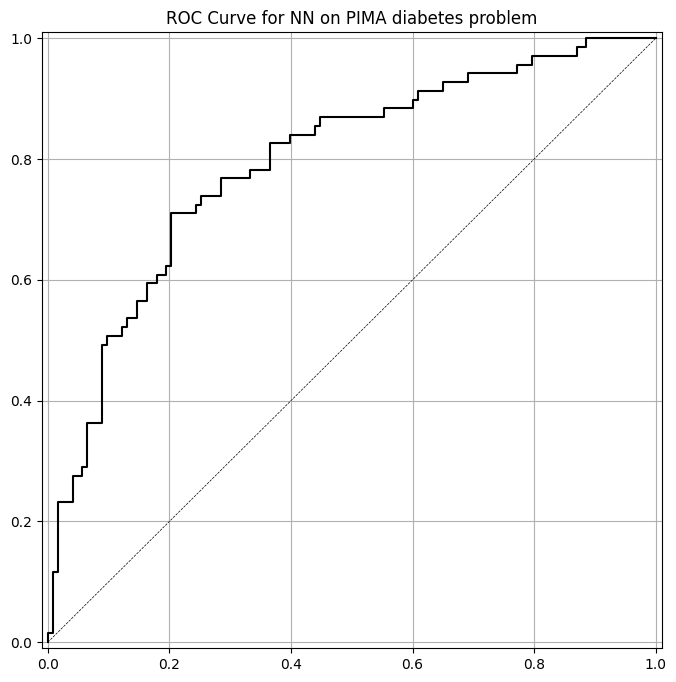

In [27]:
# Plot the roc curve for the predictions

y_pred_prob_nn_2 = model_new.predict(X_test_norm)
y_pred_class_nn_2 = (y_pred_prob_nn_2 >= 0.5).astype('int32')

print('accuracy is {:.3f}'.format(accuracy_score(y_test, y_pred_class_nn_2)))
print('roc-auc is {:.3f}'.format(roc_auc_score(y_test, y_pred_prob_nn_2)))

plot_roc(y_test, y_pred_prob_nn_2, 'NN')

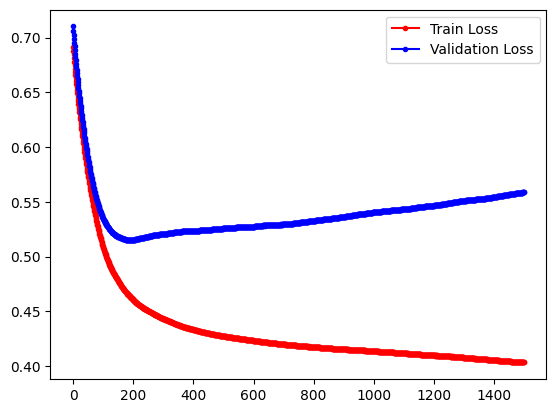

In [28]:
# Graph the trajectory of the values of loss and accuracy on both train and test set
fig, ax = plt.subplots()
ax.plot(run_hist_new.history["loss"],'r', marker='.', label="Train Loss")
ax.plot(run_hist_new.history["val_loss"],'b', marker='.', label="Validation Loss")
ax.legend()

# Workshop 5
ให้ใช้ไฟล์ jupyter notebook ของงานเดิม (สัปดาห์ที่ 4) ที่เทรนโมเดล Deep Neural Networks เพื่อทำนายผู้ป่วยโรคเบาหวาน มาปรับแก้ให้เป็นไปตามข้อกำหนด

    - ข้อกำหนด
- ให้แสดง ค่าตัววัดต่าง ๆ และกราฟของโมเดลเดิม เพื่อใช้เป็น baseline ในการพัฒนาโมเดล
- ปรับโมเดลโดยให้มีการใช้ Regularization และสามารถปรับโครงสร้างโมเดลและค่า Hyperparameters ได้ แต่ห้ามใช้ Early Stopping เพื่อให้ผลการทำนายดีขึ้น (ให้พิจารณาจากค่า accuracy)
- หลังจากเทรนโมเดลใหม่ ให้แสดง ค่าตัววัดและกราฟของโมเดลใหม่

In [36]:
import tensorflow as tf
from tensorflow.keras.regularizers import l1,l2,l1_l2

In [37]:
model_implement = tf.keras.Sequential([

    Dense(12, input_shape=(8,), activation="relu",kernel_regularizer=l2(0.04)),
    Dense(6, activation='relu',kernel_regularizer=l1(0.04)),
    tf.keras.layers.Dropout(0.3),
    Dense(1, activation = "sigmoid")
])
model_implement.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 12)                108       
                                                                 
 dense_9 (Dense)             (None, 6)                 78        
                                                                 
 dropout_1 (Dropout)         (None, 6)                 0         
                                                                 
 dense_10 (Dense)            (None, 1)                 7         
                                                                 
Total params: 193
Trainable params: 193
Non-trainable params: 0
_________________________________________________________________


In [38]:
model_implement.compile(SGD(lr = 0.003, momentum=0.3, nesterov=False), "binary_crossentropy", metrics=["accuracy"])
model_implement.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 12)                108       
                                                                 
 dense_9 (Dense)             (None, 6)                 78        
                                                                 
 dropout_1 (Dropout)         (None, 6)                 0         
                                                                 
 dense_10 (Dense)            (None, 1)                 7         
                                                                 
Total params: 193
Trainable params: 193
Non-trainable params: 0
_________________________________________________________________


In [39]:
run_hist_implement = model_implement.fit(X_train_norm, y_train, validation_data=(X_test_norm, y_test), epochs=1500)

Epoch 1/1500
18/18 [==============================] - 1s 12ms/step - loss: 1.8953 - accuracy: 0.6076 - val_loss: 1.8930 - val_accuracy: 0.5677
Epoch 2/1500
18/18 [==============================] - 0s 2ms/step - loss: 1.8878 - accuracy: 0.5660 - val_loss: 1.8716 - val_accuracy: 0.5781
Epoch 3/1500
18/18 [==============================] - 0s 2ms/step - loss: 1.8474 - accuracy: 0.6146 - val_loss: 1.8517 - val_accuracy: 0.5990
Epoch 4/1500
18/18 [==============================] - 0s 2ms/step - loss: 1.8282 - accuracy: 0.6406 - val_loss: 1.8328 - val_accuracy: 0.6094
Epoch 5/1500
18/18 [==============================] - 0s 2ms/step - loss: 1.8047 - accuracy: 0.6493 - val_loss: 1.8144 - val_accuracy: 0.6354
Epoch 6/1500
18/18 [==============================] - 0s 2ms/step - loss: 1.7915 - accuracy: 0.6389 - val_loss: 1.7965 - val_accuracy: 0.6302
Epoch 7/1500
18/18 [==============================] - 0s 3ms/step - loss: 1.7695 - accuracy: 0.6545 - val_loss: 1.7786 - val_accuracy: 0.6302
Epoch

18/18 [==============================] - 0s 2ms/step - loss: 0.8315 - accuracy: 0.7135 - val_loss: 0.8383 - val_accuracy: 0.7135
Epoch 116/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.8335 - accuracy: 0.6910 - val_loss: 0.8345 - val_accuracy: 0.7083
Epoch 117/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.8328 - accuracy: 0.7205 - val_loss: 0.8306 - val_accuracy: 0.7083
Epoch 118/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.8208 - accuracy: 0.7274 - val_loss: 0.8268 - val_accuracy: 0.7083
Epoch 119/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.8204 - accuracy: 0.7135 - val_loss: 0.8231 - val_accuracy: 0.7083
Epoch 120/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.8205 - accuracy: 0.7222 - val_loss: 0.8195 - val_accuracy: 0.7083
Epoch 121/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.8104 - accuracy: 0.7222 - val_loss: 0.8159 - val_accuracy: 0.7083
Epoch 1

Epoch 172/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.6916 - accuracy: 0.7222 - val_loss: 0.6942 - val_accuracy: 0.7344
Epoch 173/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.6924 - accuracy: 0.7240 - val_loss: 0.6926 - val_accuracy: 0.7344
Epoch 174/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.6918 - accuracy: 0.7222 - val_loss: 0.6912 - val_accuracy: 0.7344
Epoch 175/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.6886 - accuracy: 0.7153 - val_loss: 0.6900 - val_accuracy: 0.7344
Epoch 176/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.6872 - accuracy: 0.7205 - val_loss: 0.6887 - val_accuracy: 0.7344
Epoch 177/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.6878 - accuracy: 0.7170 - val_loss: 0.6877 - val_accuracy: 0.7344
Epoch 178/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.6885 - accuracy: 0.7240 - val_loss: 0.6865 - val_accuracy:

Epoch 229/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.6481 - accuracy: 0.7205 - val_loss: 0.6469 - val_accuracy: 0.7344
Epoch 230/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.6496 - accuracy: 0.7188 - val_loss: 0.6462 - val_accuracy: 0.7344
Epoch 231/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.6565 - accuracy: 0.7257 - val_loss: 0.6457 - val_accuracy: 0.7344
Epoch 232/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.6483 - accuracy: 0.7326 - val_loss: 0.6450 - val_accuracy: 0.7396
Epoch 233/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.6551 - accuracy: 0.7274 - val_loss: 0.6444 - val_accuracy: 0.7448
Epoch 234/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.6510 - accuracy: 0.7205 - val_loss: 0.6439 - val_accuracy: 0.7500
Epoch 235/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.6441 - accuracy: 0.7361 - val_loss: 0.6433 - val_accuracy:

Epoch 286/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.6152 - accuracy: 0.7483 - val_loss: 0.6187 - val_accuracy: 0.7812
Epoch 287/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.6215 - accuracy: 0.7396 - val_loss: 0.6183 - val_accuracy: 0.7812
Epoch 288/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.6249 - accuracy: 0.7326 - val_loss: 0.6179 - val_accuracy: 0.7812
Epoch 289/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.6223 - accuracy: 0.7378 - val_loss: 0.6176 - val_accuracy: 0.7812
Epoch 290/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.6185 - accuracy: 0.7431 - val_loss: 0.6173 - val_accuracy: 0.7812
Epoch 291/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.6204 - accuracy: 0.7396 - val_loss: 0.6170 - val_accuracy: 0.7812
Epoch 292/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.6203 - accuracy: 0.7396 - val_loss: 0.6166 - val_accuracy:

Epoch 343/1500
18/18 [==============================] - 0s 3ms/step - loss: 0.6070 - accuracy: 0.7309 - val_loss: 0.6038 - val_accuracy: 0.7812
Epoch 344/1500
18/18 [==============================] - 0s 3ms/step - loss: 0.6125 - accuracy: 0.7413 - val_loss: 0.6037 - val_accuracy: 0.7812
Epoch 345/1500
18/18 [==============================] - 0s 3ms/step - loss: 0.6043 - accuracy: 0.7448 - val_loss: 0.6036 - val_accuracy: 0.7812
Epoch 346/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.6059 - accuracy: 0.7500 - val_loss: 0.6032 - val_accuracy: 0.7812
Epoch 347/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.6105 - accuracy: 0.7413 - val_loss: 0.6030 - val_accuracy: 0.7812
Epoch 348/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.6148 - accuracy: 0.7378 - val_loss: 0.6030 - val_accuracy: 0.7812
Epoch 349/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.5986 - accuracy: 0.7483 - val_loss: 0.6026 - val_accuracy:

Epoch 400/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.5949 - accuracy: 0.7413 - val_loss: 0.5947 - val_accuracy: 0.7760
Epoch 401/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.5931 - accuracy: 0.7274 - val_loss: 0.5944 - val_accuracy: 0.7760
Epoch 402/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.6030 - accuracy: 0.7274 - val_loss: 0.5944 - val_accuracy: 0.7760
Epoch 403/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.6008 - accuracy: 0.7309 - val_loss: 0.5942 - val_accuracy: 0.7760
Epoch 404/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.6011 - accuracy: 0.7274 - val_loss: 0.5939 - val_accuracy: 0.7760
Epoch 405/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.6069 - accuracy: 0.7361 - val_loss: 0.5938 - val_accuracy: 0.7760
Epoch 406/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.5918 - accuracy: 0.7483 - val_loss: 0.5936 - val_accuracy:

Epoch 457/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.5899 - accuracy: 0.7344 - val_loss: 0.5880 - val_accuracy: 0.7708
Epoch 458/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.5756 - accuracy: 0.7396 - val_loss: 0.5877 - val_accuracy: 0.7708
Epoch 459/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.5935 - accuracy: 0.7431 - val_loss: 0.5874 - val_accuracy: 0.7708
Epoch 460/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.6055 - accuracy: 0.7309 - val_loss: 0.5874 - val_accuracy: 0.7708
Epoch 461/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.5957 - accuracy: 0.7309 - val_loss: 0.5874 - val_accuracy: 0.7708
Epoch 462/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.5982 - accuracy: 0.7344 - val_loss: 0.5874 - val_accuracy: 0.7708
Epoch 463/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.5916 - accuracy: 0.7448 - val_loss: 0.5871 - val_accuracy:

Epoch 514/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.5879 - accuracy: 0.7396 - val_loss: 0.5835 - val_accuracy: 0.7656
Epoch 515/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.6050 - accuracy: 0.7361 - val_loss: 0.5836 - val_accuracy: 0.7656
Epoch 516/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.5894 - accuracy: 0.7396 - val_loss: 0.5835 - val_accuracy: 0.7656
Epoch 517/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.5985 - accuracy: 0.7153 - val_loss: 0.5836 - val_accuracy: 0.7656
Epoch 518/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.5861 - accuracy: 0.7500 - val_loss: 0.5835 - val_accuracy: 0.7656
Epoch 519/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.5903 - accuracy: 0.7465 - val_loss: 0.5834 - val_accuracy: 0.7656
Epoch 520/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.5963 - accuracy: 0.7448 - val_loss: 0.5833 - val_accuracy:

Epoch 571/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.5941 - accuracy: 0.7205 - val_loss: 0.5795 - val_accuracy: 0.7656
Epoch 572/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.5711 - accuracy: 0.7604 - val_loss: 0.5792 - val_accuracy: 0.7656
Epoch 573/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.5898 - accuracy: 0.7465 - val_loss: 0.5791 - val_accuracy: 0.7708
Epoch 574/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.5893 - accuracy: 0.7240 - val_loss: 0.5793 - val_accuracy: 0.7656
Epoch 575/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.5990 - accuracy: 0.7257 - val_loss: 0.5795 - val_accuracy: 0.7708
Epoch 576/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.6052 - accuracy: 0.7153 - val_loss: 0.5798 - val_accuracy: 0.7708
Epoch 577/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.5720 - accuracy: 0.7587 - val_loss: 0.5792 - val_accuracy:

Epoch 628/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.5808 - accuracy: 0.7344 - val_loss: 0.5738 - val_accuracy: 0.7708
Epoch 629/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.5865 - accuracy: 0.7344 - val_loss: 0.5737 - val_accuracy: 0.7708
Epoch 630/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.5786 - accuracy: 0.7431 - val_loss: 0.5737 - val_accuracy: 0.7708
Epoch 631/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.5818 - accuracy: 0.7431 - val_loss: 0.5736 - val_accuracy: 0.7708
Epoch 632/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.6009 - accuracy: 0.7222 - val_loss: 0.5739 - val_accuracy: 0.7708
Epoch 633/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.5815 - accuracy: 0.7396 - val_loss: 0.5739 - val_accuracy: 0.7708
Epoch 634/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.5839 - accuracy: 0.7257 - val_loss: 0.5739 - val_accuracy:

Epoch 685/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.5698 - accuracy: 0.7431 - val_loss: 0.5705 - val_accuracy: 0.7708
Epoch 686/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.5654 - accuracy: 0.7517 - val_loss: 0.5704 - val_accuracy: 0.7760
Epoch 687/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.5760 - accuracy: 0.7431 - val_loss: 0.5704 - val_accuracy: 0.7708
Epoch 688/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.5737 - accuracy: 0.7361 - val_loss: 0.5703 - val_accuracy: 0.7708
Epoch 689/1500
18/18 [==============================] - 0s 3ms/step - loss: 0.5803 - accuracy: 0.7396 - val_loss: 0.5702 - val_accuracy: 0.7708
Epoch 690/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.5729 - accuracy: 0.7413 - val_loss: 0.5699 - val_accuracy: 0.7708
Epoch 691/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.5848 - accuracy: 0.7292 - val_loss: 0.5701 - val_accuracy:

Epoch 742/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.5727 - accuracy: 0.7465 - val_loss: 0.5679 - val_accuracy: 0.7760
Epoch 743/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.5776 - accuracy: 0.7257 - val_loss: 0.5679 - val_accuracy: 0.7760
Epoch 744/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.5820 - accuracy: 0.7378 - val_loss: 0.5681 - val_accuracy: 0.7760
Epoch 745/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.5890 - accuracy: 0.7153 - val_loss: 0.5684 - val_accuracy: 0.7760
Epoch 746/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.5883 - accuracy: 0.7205 - val_loss: 0.5688 - val_accuracy: 0.7708
Epoch 747/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.5750 - accuracy: 0.7517 - val_loss: 0.5687 - val_accuracy: 0.7708
Epoch 748/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.5791 - accuracy: 0.7274 - val_loss: 0.5688 - val_accuracy:

Epoch 799/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.5910 - accuracy: 0.7205 - val_loss: 0.5672 - val_accuracy: 0.7656
Epoch 800/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.5766 - accuracy: 0.7413 - val_loss: 0.5672 - val_accuracy: 0.7708
Epoch 801/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.5730 - accuracy: 0.7517 - val_loss: 0.5671 - val_accuracy: 0.7656
Epoch 802/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.5752 - accuracy: 0.7448 - val_loss: 0.5670 - val_accuracy: 0.7656
Epoch 803/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.5626 - accuracy: 0.7535 - val_loss: 0.5669 - val_accuracy: 0.7760
Epoch 804/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.5764 - accuracy: 0.7309 - val_loss: 0.5669 - val_accuracy: 0.7760
Epoch 805/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.5551 - accuracy: 0.7465 - val_loss: 0.5666 - val_accuracy:

Epoch 856/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.5635 - accuracy: 0.7535 - val_loss: 0.5667 - val_accuracy: 0.7760
Epoch 857/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.5721 - accuracy: 0.7431 - val_loss: 0.5668 - val_accuracy: 0.7760
Epoch 858/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.5752 - accuracy: 0.7431 - val_loss: 0.5667 - val_accuracy: 0.7708
Epoch 859/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.5799 - accuracy: 0.7257 - val_loss: 0.5668 - val_accuracy: 0.7708
Epoch 860/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.5733 - accuracy: 0.7535 - val_loss: 0.5667 - val_accuracy: 0.7708
Epoch 861/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.5646 - accuracy: 0.7448 - val_loss: 0.5667 - val_accuracy: 0.7708
Epoch 862/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.5755 - accuracy: 0.7344 - val_loss: 0.5666 - val_accuracy:

Epoch 913/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.5637 - accuracy: 0.7344 - val_loss: 0.5661 - val_accuracy: 0.7708
Epoch 914/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.5750 - accuracy: 0.7292 - val_loss: 0.5660 - val_accuracy: 0.7708
Epoch 915/1500
18/18 [==============================] - 0s 3ms/step - loss: 0.5714 - accuracy: 0.7413 - val_loss: 0.5659 - val_accuracy: 0.7708
Epoch 916/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.5730 - accuracy: 0.7257 - val_loss: 0.5659 - val_accuracy: 0.7708
Epoch 917/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.5667 - accuracy: 0.7431 - val_loss: 0.5657 - val_accuracy: 0.7656
Epoch 918/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.5860 - accuracy: 0.7188 - val_loss: 0.5661 - val_accuracy: 0.7656
Epoch 919/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.5670 - accuracy: 0.7465 - val_loss: 0.5657 - val_accuracy:

Epoch 970/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.5665 - accuracy: 0.7326 - val_loss: 0.5645 - val_accuracy: 0.7708
Epoch 971/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.5684 - accuracy: 0.7309 - val_loss: 0.5645 - val_accuracy: 0.7708
Epoch 972/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.5778 - accuracy: 0.7309 - val_loss: 0.5651 - val_accuracy: 0.7708
Epoch 973/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.5620 - accuracy: 0.7361 - val_loss: 0.5646 - val_accuracy: 0.7708
Epoch 974/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.5904 - accuracy: 0.7292 - val_loss: 0.5648 - val_accuracy: 0.7708
Epoch 975/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.5796 - accuracy: 0.7135 - val_loss: 0.5650 - val_accuracy: 0.7708
Epoch 976/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.5814 - accuracy: 0.7205 - val_loss: 0.5650 - val_accuracy:

Epoch 1027/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.5557 - accuracy: 0.7378 - val_loss: 0.5627 - val_accuracy: 0.7656
Epoch 1028/1500
18/18 [==============================] - 0s 4ms/step - loss: 0.5642 - accuracy: 0.7448 - val_loss: 0.5628 - val_accuracy: 0.7656
Epoch 1029/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.5521 - accuracy: 0.7517 - val_loss: 0.5622 - val_accuracy: 0.7656
Epoch 1030/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.5744 - accuracy: 0.7170 - val_loss: 0.5624 - val_accuracy: 0.7656
Epoch 1031/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.5648 - accuracy: 0.7361 - val_loss: 0.5623 - val_accuracy: 0.7656
Epoch 1032/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.5765 - accuracy: 0.7378 - val_loss: 0.5624 - val_accuracy: 0.7656
Epoch 1033/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.5818 - accuracy: 0.7274 - val_loss: 0.5627 - val_ac

18/18 [==============================] - 0s 2ms/step - loss: 0.5667 - accuracy: 0.7344 - val_loss: 0.5620 - val_accuracy: 0.7656
Epoch 1140/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.5762 - accuracy: 0.7292 - val_loss: 0.5624 - val_accuracy: 0.7708
Epoch 1141/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.5764 - accuracy: 0.7188 - val_loss: 0.5624 - val_accuracy: 0.7656
Epoch 1142/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.5599 - accuracy: 0.7569 - val_loss: 0.5621 - val_accuracy: 0.7708
Epoch 1143/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.5663 - accuracy: 0.7292 - val_loss: 0.5621 - val_accuracy: 0.7708
Epoch 1144/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.5569 - accuracy: 0.7500 - val_loss: 0.5617 - val_accuracy: 0.7656
Epoch 1145/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.5734 - accuracy: 0.7465 - val_loss: 0.5618 - val_accuracy: 0.7708
E

18/18 [==============================] - 0s 2ms/step - loss: 0.5586 - accuracy: 0.7465 - val_loss: 0.5596 - val_accuracy: 0.7656
Epoch 1252/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.5470 - accuracy: 0.7535 - val_loss: 0.5589 - val_accuracy: 0.7708
Epoch 1253/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.5625 - accuracy: 0.7292 - val_loss: 0.5591 - val_accuracy: 0.7708
Epoch 1254/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.5686 - accuracy: 0.7292 - val_loss: 0.5593 - val_accuracy: 0.7708
Epoch 1255/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.5608 - accuracy: 0.7361 - val_loss: 0.5595 - val_accuracy: 0.7708
Epoch 1256/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.5590 - accuracy: 0.7413 - val_loss: 0.5598 - val_accuracy: 0.7708
Epoch 1257/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.5605 - accuracy: 0.7309 - val_loss: 0.5599 - val_accuracy: 0.7708
E

18/18 [==============================] - 0s 2ms/step - loss: 0.5473 - accuracy: 0.7569 - val_loss: 0.5589 - val_accuracy: 0.7708
Epoch 1364/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.5562 - accuracy: 0.7517 - val_loss: 0.5588 - val_accuracy: 0.7708
Epoch 1365/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.5655 - accuracy: 0.7413 - val_loss: 0.5589 - val_accuracy: 0.7708
Epoch 1366/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.5624 - accuracy: 0.7396 - val_loss: 0.5590 - val_accuracy: 0.7708
Epoch 1367/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.5639 - accuracy: 0.7396 - val_loss: 0.5591 - val_accuracy: 0.7708
Epoch 1368/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.5677 - accuracy: 0.7413 - val_loss: 0.5588 - val_accuracy: 0.7708
Epoch 1369/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.5561 - accuracy: 0.7587 - val_loss: 0.5585 - val_accuracy: 0.7708
E

18/18 [==============================] - 0s 2ms/step - loss: 0.5730 - accuracy: 0.7448 - val_loss: 0.5585 - val_accuracy: 0.7708
Epoch 1476/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.5612 - accuracy: 0.7396 - val_loss: 0.5586 - val_accuracy: 0.7708
Epoch 1477/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.5540 - accuracy: 0.7378 - val_loss: 0.5583 - val_accuracy: 0.7708
Epoch 1478/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.5614 - accuracy: 0.7188 - val_loss: 0.5582 - val_accuracy: 0.7708
Epoch 1479/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.5661 - accuracy: 0.7413 - val_loss: 0.5582 - val_accuracy: 0.7708
Epoch 1480/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.5567 - accuracy: 0.7378 - val_loss: 0.5581 - val_accuracy: 0.7708
Epoch 1481/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.5704 - accuracy: 0.7274 - val_loss: 0.5584 - val_accuracy: 0.7656
E

6/6 [==============================] - 0s 1ms/step
accuracy is 0.771
roc-auc is 0.825


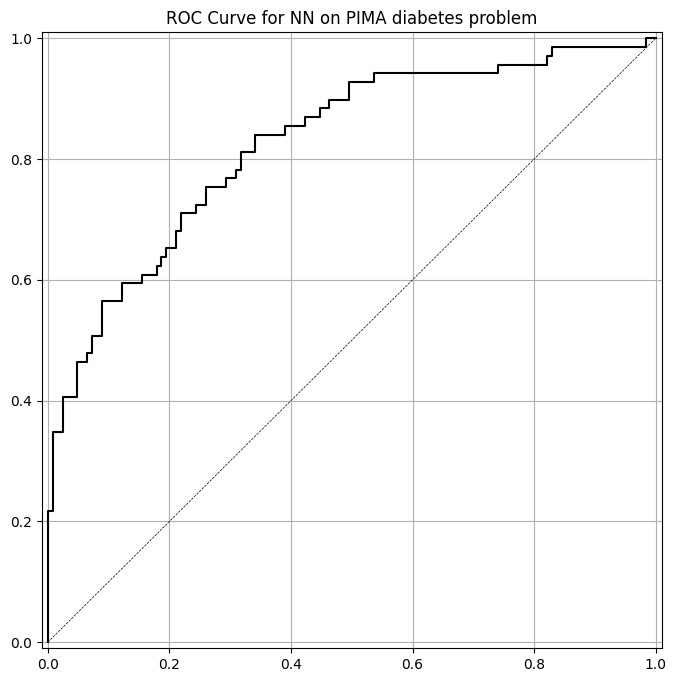

In [40]:
# Plot the roc curve for the predictions

y_pred_prob_nn_2 = model_implement.predict(X_test_norm)
y_pred_class_nn_2 = (y_pred_prob_nn_2 >= 0.5).astype('int32')

print('accuracy is {:.3f}'.format(accuracy_score(y_test, y_pred_class_nn_2)))
print('roc-auc is {:.3f}'.format(roc_auc_score(y_test, y_pred_prob_nn_2)))

plot_roc(y_test, y_pred_prob_nn_2, 'NN')

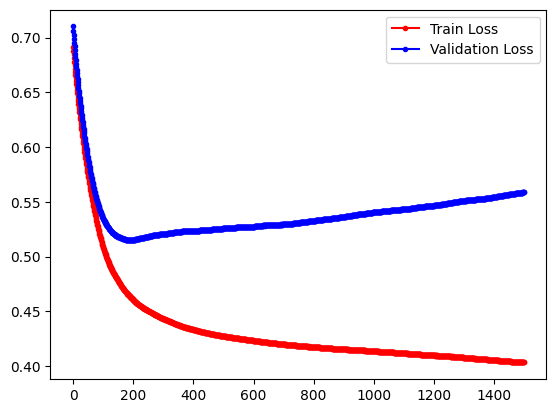

In [41]:
fig, ax = plt.subplots()
ax.plot(run_hist_new.history["loss"],'r', marker='.', label="Train Loss")
ax.plot(run_hist_new.history["val_loss"],'b', marker='.', label="Validation Loss")
ax.legend()

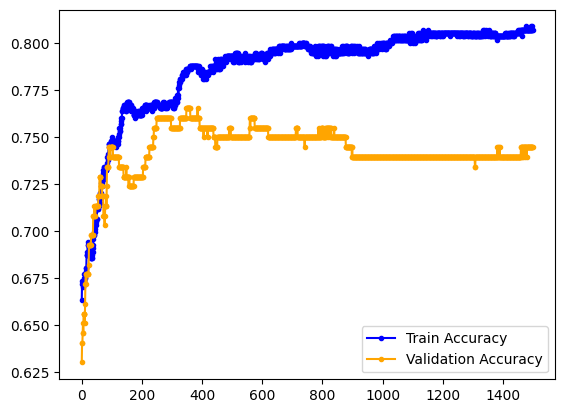

In [42]:
fig, ax = plt.subplots()
ax.plot(run_hist_new.history["accuracy"], 'blue', marker='.', label="Train Accuracy")
ax.plot(run_hist_new.history["val_accuracy"], 'orange', marker='.', label="Validation Accuracy")
ax.legend()
plt.show()